In [5]:
#Installing the required tensorflow libraries
!pip install tensorflow==2.2.0

In [6]:
!nvidia-smi

Fri Jun  4 11:40:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# Importing the libraries

import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import Xception,ResNet152V2
from tensorflow.python.keras.saving import hdf5_format
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from google.colab import drive
import h5py, itertools, collections
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report

In [14]:
# Download dataset:
!wget http://206.12.93.90:8080/simpson_dataset/simpsons_train.tar.gz 
# Unzip the dataset:
!tar -xzvf simpsons_train.tar.gz > /dev/null

--2021-06-04 11:43:30--  http://206.12.93.90:8080/simpson_dataset/simpsons_train.tar.gz
Connecting to 206.12.93.90:8080... connected.
HTTP request sent, awaiting response... 200 
Length: 488194922 (466M) [application/x-gzip]
Saving to: ‘simpsons_train.tar.gz’

simpsons_train.tar. 100%[===================>] 465.58M  19.2MB/s    in 25s     

2021-06-04 11:43:55 (18.6 MB/s) - ‘simpsons_train.tar.gz’ saved [488194922/488194922]



# Train - test split and build data pipelines that enables data augmentation

In [15]:
'''
    Split train and validation.
'''
# We define the size of input images to 224x224 pixels.
image_size = (224, 224)

EPOCHS = 40

# We define the batch size
batch_size = 64

# Create an image generator with a fraction of images reserved for validation:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        fill_mode='nearest',
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "dataset/simpsons_train/",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    "dataset/simpsons_train/", # same directory as training data
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation') # set as validation data

# We save the list of classes (labels).
class_names = list(train_generator.class_indices.keys())

# We also save the number of labels.
num_classes = train_generator.num_classes

Found 15648 images belonging to 20 classes.
Found 3900 images belonging to 20 classes.


In [16]:
#Loading the ResNet152V2 model.The inputs should be in the shape 224x224 as ResNet152V2 is trained on image dimension of 224x224.

base_model = ResNet152V2(weights='imagenet',input_shape=(224,224,3),include_top=False)

234553344/234545216 [==============================] - 4s 0us/step


In [17]:
# Code on not to retrain the existing layers as the layers have already been trained

for layer in base_model.layers:
    layer.trainable=True

In [21]:
#Creating our own layers

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Flatten()(top_model)
top_model = Dense(1024, activation="relu")(top_model)
top_model = Dense(1024, activation="relu")(top_model)
top_model = Dense(512, activation="relu")(top_model)
# and a softmax/logistic layer -- we have 6 classes
predictions = Dense(20, activation='softmax')(top_model)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#Plotting the model to model.png file
tensorflow.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

#Printing the summary of the model
model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.526225 to fit

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________

Learning rate schedule: 0.0001 to 0.0005 to 0.0001


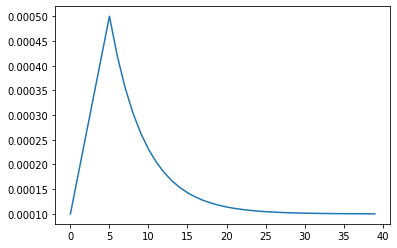

In [ ]:
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.0001
LR_MAX = 0.0005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
#Adding checkpoints

modelName= "resnet_152v2"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_delta=0.0001)
schedule_lr = LearningRateScheduler(lrfn, verbose=1)

callbacks_list = [checkpoint, schedule_lr, early_stopping, reduce_lr]

In [ ]:
# Compiling the model

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Calculating the steps per epoch and validation steps

stepsPerEpoch= (train_generator.samples+ (batch_size-1)) // batch_size
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batch_size-1)) // batch_size
print("validationSteps: ", validationSteps)

stepsPerEpoch:  245
validationSteps:  61


# Training the model

In [ ]:
# Fit the model
history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = EPOCHS,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
245/245 [==============================] - ETA: 0s - loss: 0.8991 - accuracy: 0.7415
Epoch 00001: val_accuracy improved from -inf to 0.92641, saving model to xception_test_bestweights.h5
245/245 [==============================] - 216s 883ms/step - loss: 0.8991 - accuracy: 0.7415 - val_loss: 0.2682 - val_accuracy: 0.9264 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00018.
Epoch 2/40
245/245 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9530
Epoch 00002: val_accuracy improved from 0.92641 to 0.94103, saving model to xception_test_bestweights.h5
245/245 [==============================] - 215s 879ms/step - loss: 0.1757 - accuracy: 0.9530 - val_loss: 0.2128 - val_accuracy: 0.9410 - lr: 1.8000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00026000000000000003.
Epoch 3/40
245/245 [==============================] - ETA: 0s - loss: 

# Check for overfitting

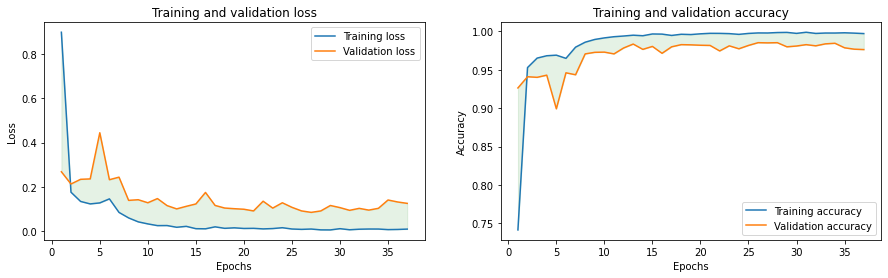

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification report and Confusion Matrix

In [ ]:
validation_generator.reset()
validation_generator.shuffle = False
validation_generator.next()
y_prob = model.predict(validation_generator)
y_pred = y_prob.argmax(axis=-1)
y_true = validation_generator.labels
print(classification_report(y_true, y_pred, target_names=class_names))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.95      0.98      0.97       182
  apu_nahasapeemapetilon       1.00      1.00      1.00       124
            bart_simpson       0.98      0.99      0.98       268
charles_montgomery_burns       0.99      0.99      0.99       238
            chief_wiggum       0.98      0.97      0.98       197
          comic_book_guy       0.99      0.96      0.97        93
          edna_krabappel       0.97      0.97      0.97        91
           homer_simpson       0.99      0.98      0.98       449
           kent_brockman       0.96      0.99      0.98        99
        krusty_the_clown       0.98      0.99      0.98       241
           lenny_leonard       0.98      0.95      0.97        62
            lisa_simpson       1.00      0.98      0.99       270
           marge_simpson       0.99      0.99      0.99       258
            mayor_quimby       0.98      0.96      0.97        49
     milh

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)

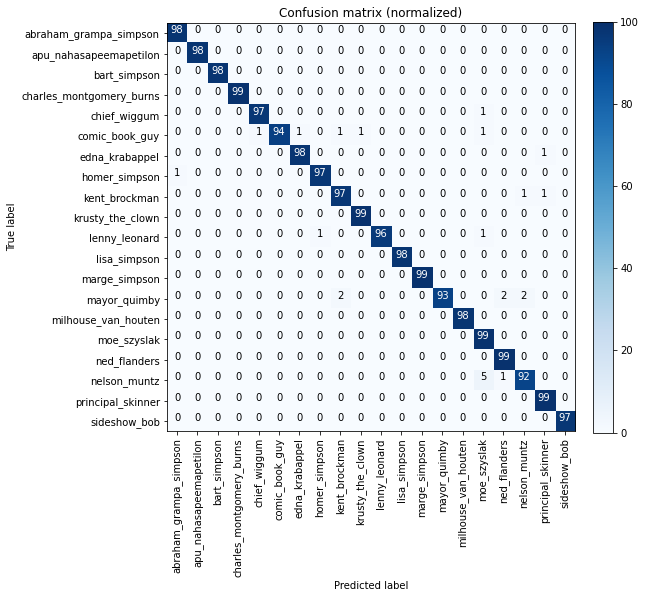

In [ ]:
validation_generator.reset()
validation_generator.shuffle = False
validation_generator.next()
y_prob = model.predict(validation_generator)
y_pred = y_prob.argmax(axis=-1)
y_true = validation_generator.labels
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)

# Analysing the predictions of the model

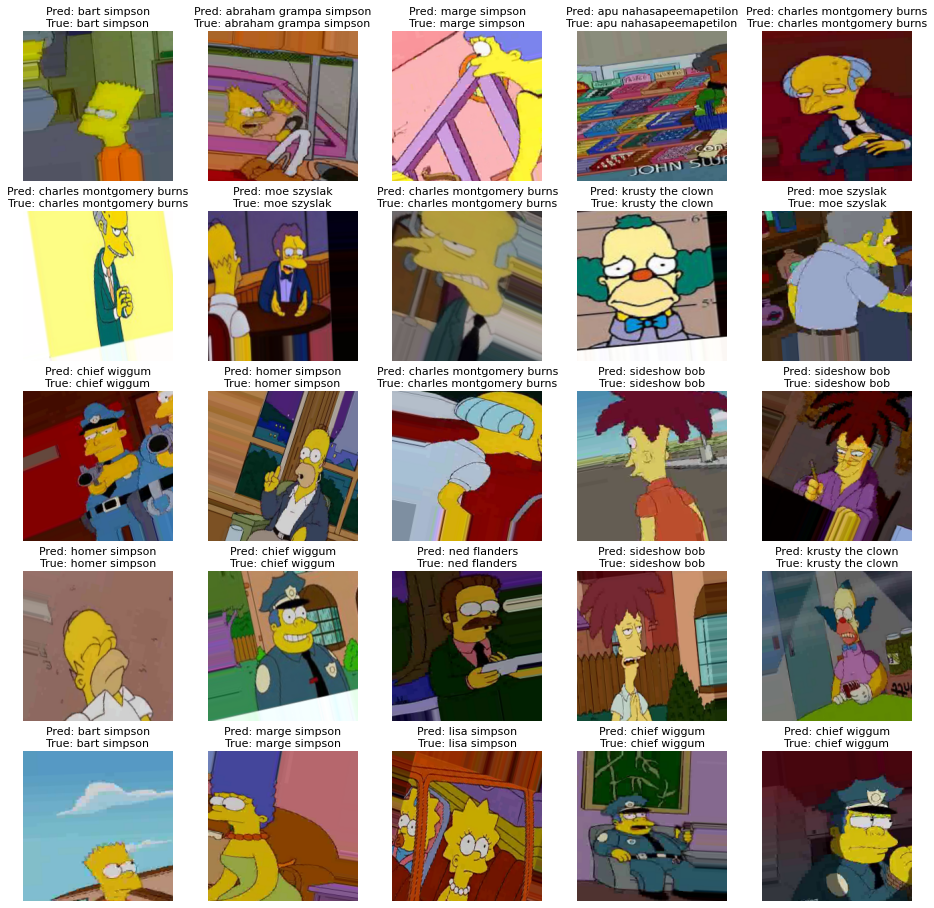

In [ ]:
validation_generator.reset()
validation_generator.shuffle = True
#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels_pred = []
labels_true = []
for itr in validation_generator.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 
    
    
    plt.title(title,fontsize= 11, pad=5)
    plt.axis("off")
#     plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1, wspace=None, hspace=None)

# Saving the model to google colab

In [ ]:
#Mounting the google colab drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('model.h5')

In [ ]:
with h5py.File('model.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['class_names'] = class_names
    f.attrs['image_size'] = image_size

In [ ]:
!cp model.h5 'drive/My Drive/'

In [ ]:
from platform import python_version

print(python_version())

3.7.10
